## Tweet Emotion Recognition: Natural Language Processing with TensorFlow


Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.1 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
!pip install datasets==2.9.0

from datasets import load_dataset
# emotions_ds = load_dataset("emotion")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 12.9 MB/s eta 0:00:00


In [4]:
dataset = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [7]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [8]:
tweets, labels = get_tweet(train)

In [9]:
tweets[12], labels[12]

('i think it s the easiest time of year to feel dissatisfied', 3)

## Tokenizer

1. Tokenizing the tweets

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
# oov - out of vocabulary
tokenizer = Tokenizer(num_words = 10000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

In [12]:
tweets[0]

'i didnt feel humiliated'

In [13]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

##  Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

(array([  8.,  45., 310., 488., 539., 625., 626., 629., 613., 636., 654.,
        655., 608., 622., 609., 603., 559., 535., 530., 510., 452., 430.,
        382., 385., 330., 327., 336., 317., 238., 208., 200., 200., 167.,
        157., 141., 144., 120., 117., 117.,  88.,  96.,  72.,  66.,  66.,
         65.,  52.,  37.,  43.,  30.,  32.,  31.,  26.,  30.,  20.,  23.,
         14.,   9.,  10.,   4.,   4.,   4.,   1.,   4.,   1.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
        41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
        54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66.]),
 <BarContainer object of 64 artists>)

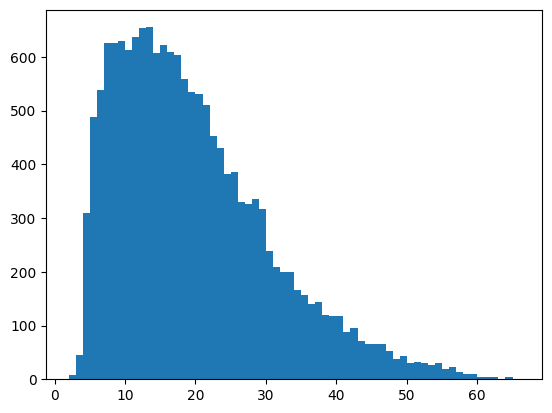

In [14]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))

In [15]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = maxlen)
  return padded

In [17]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [18]:
padded_train_seq[56]

array([   2,  232,  407,  736,   11, 2481, 3071,   37,   13, 1212,   74,
         77, 2482,    5,   28,   77, 5279,    5,   18,   37,  507, 2124,
         16,   18,    5,  331,  136,    2,   70,   66,  123,    9,   66,
        612,    5,   80,   18,    3,   29,  593,   29,  889,   15,  212,
        300,    0,    0,    0,    0,    0], dtype=int32)

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [19]:
classes = set(labels)
print(classes)
# 0-sadness, 1-joy, 2-love, 3-anger, 4-fear, 5-surprise

{0, 1, 2, 3, 4, 5}


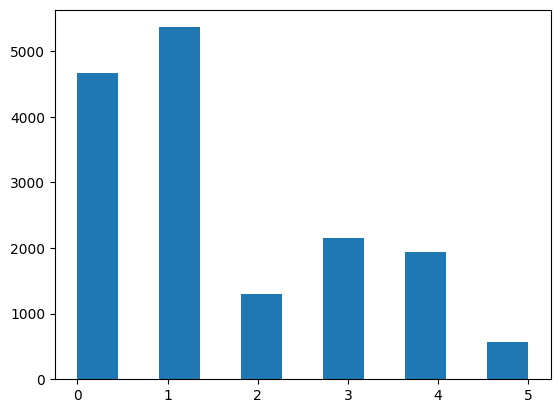

In [20]:
plt.hist(labels, bins = 11)
plt.show()

In [21]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [22]:
class_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [23]:
index_to_class

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [24]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [25]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Creating the Model

1. Creating the model
2. Compiling the model

In [26]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation = 'softmax')
])

In [28]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [30]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [31]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [32]:
h = model.fit(
    padded_train_seq, train_labels, 
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/20
500/500 [==============================] - 46s 64ms/step - loss: 1.2854 - accuracy: 0.4999 - val_loss: 0.7880 - val_accuracy: 0.6960
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.5353 - accuracy: 0.8162 - val_loss: 0.5169 - val_accuracy: 0.8240
Epoch 3/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3261 - accuracy: 0.8882 - val_loss: 0.5262 - val_accuracy: 0.8225
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2273 - accuracy: 0.9244 - val_loss: 0.4751 - val_accuracy: 0.8485
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 0.1745 - accuracy: 0.9433 - val_loss: 0.4129 - val_accuracy: 0.8720
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.1345 - accuracy: 0.9582 - val_loss: 0.4035 - val_accuracy: 0.8790
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1028 - accuracy: 0.9678 - val_loss: 0.3861 - val_accuracy: 0.8

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

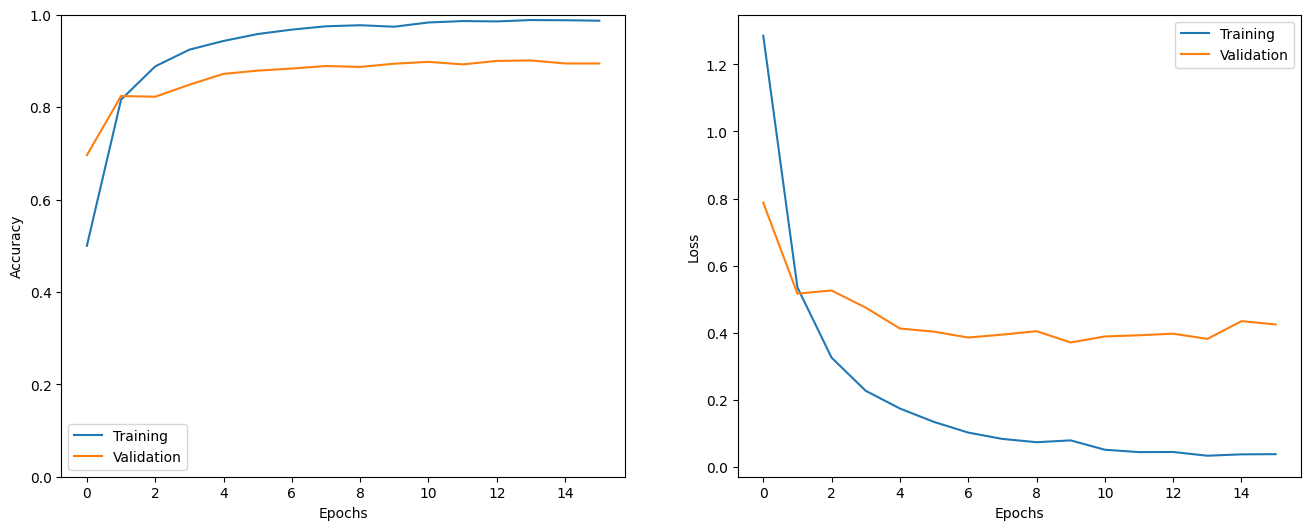

In [33]:
show_history(h)

In [35]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [36]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 10ms/step - loss: 0.4924 - accuracy: 0.8825


In [39]:
i = random.randint(0, len(test_labels)-1)
print('sentence: ', test_tweets[i])
print('emotion: ', index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('predicted emotion: ', pred_class)

sentence:  i feel doubtful in my abilities
emotion:  4
1/1 [==============================] - 1s 1s/step
predicted emotion:  4


In [57]:
preds = model.predict(test_seq)
preds = np.argmax(preds, axis=1)

63/63 [==============================] - 0s 7ms/step


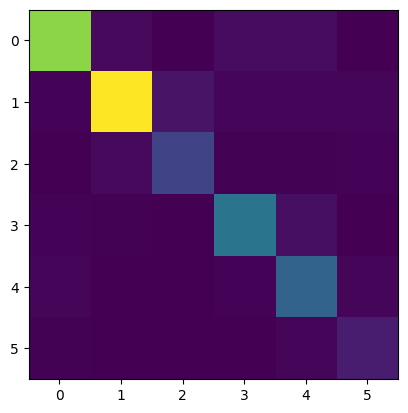

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, list(preds))
plt.imshow(cm)